In [1]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

import matplotlib.pyplot as plt



[[30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]]


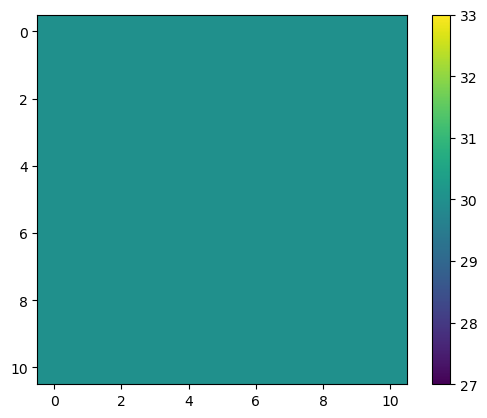

In [2]:
def IdealModel1(wel: list = [0.0, 0.0, 0.0]) -> list:
    import os
    import numpy as np
    import pandas as pd
    import flopy
    from tempfile import TemporaryDirectory

    # filename
    temp_dir = TemporaryDirectory()
    sim_ws = os.path.join(temp_dir.name)
    sim_name = "IdealModel1"
    gwfname = "gwf_" + sim_name
    gwtname = "gwt_" + sim_name

    # units
    length_units = "meters"
    time_units = "days"

    # Discretization
    nper = 1
    nlay = 1
    nrow = 11
    ncol = 11
    delr = 1000
    delc = 1000
    top = 30
    botm = -10
    idomain = 1

    # GWF
    icelltype = 1  # 潜水含水层

    k11 = np.full([11, 11], 90)  # 渗透系数
    k11[:4, :6] = 150
    k11[8:, :] = 60
    k11[5:8, 9:] = 60

    # Temporal discretization
    perlen = 1000.0
    nstp = 1
    tsmult = 1.0
    tdis_ds = []
    tdis_ds.append((perlen, nstp, tsmult))

    # Solver parameters
    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-6, 1e-6, 1.0

    # Initial conditions
    # Starting Heads
    strt = np.full([11, 11], 30, dtype=float)

    # Boundary conditions
    # wel_spd

    wel_spd = [[0, 2, 3, -wel[0]], [0, 5, 4, -wel[1]], [0, 6, 10, -wel[2]]]
    wel_spd = {0: wel_spd}

    # chd_spd
    chd_spd = []
    for i in np.arange(ncol):
        chd_spd.append([0, 10, i, 30.0])

    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)

    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file="{}.nam".format(gwfname),
    )

    ims = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename="{}.ims".format(gwfname),
    )
    sim.register_ims_package(ims, [gwf.name])

    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename="{}.dis".format(gwfname),
    )

    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=icelltype,
        k=k11,
        k33=k11,
        save_specific_discharge=True,
        filename="{}.npf".format(gwfname),
    )

    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename="{}.ic".format(gwfname))

    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chd_spd),
        stress_period_data=chd_spd,
        save_flows=False,
        pname="CHD-1",
        filename="{}.chd".format(gwfname),
    )

    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        stress_period_data=wel_spd,
        save_flows=True,
        pname="WEL-1",
        filename="{}.wel".format(gwfname),
    )

    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord="{}.hds".format(gwfname),
        budget_filerecord="{}.bud".format(gwfname),
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    sim.write_simulation(silent=True)
    success, buff = sim.run_simulation(silent=True)
    if not success:
        raise Exception("MODFLOW 6 did not terminate normally.")

    head = gwf.oc.output.head().get_alldata()[0, 0]

    return head


import matplotlib.pyplot as plt
import numpy as np

# test = np.array([10000, 10000, 10000])
# res = IdealModel1(test)
res = IdealModel1()
print(res)
plt.imshow(res)
plt.colorbar()
plt.show()

In [3]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3

from pymoo.core.problem import ElementwiseProblem

from pymoo.optimize import minimize

from pymoo.operators.crossover.sbx import SBX

from pymoo.operators.sampling.rnd import FloatRandomSampling

from pymoo.operators.mutation.pm import PolynomialMutation

from pymoo.visualization.scatter import Scatter


import matplotlib.pyplot as plt

import numpy as np



class gwProblem_IdealModel1(ElementwiseProblem):

    def __init__(self):

        super().__init__(

            n_var=3,  # 变量数，三口井抽水量

            n_obj=2,  # 目标数，最大化抽水总量和最小化网格水位降深

            n_constr=4,  # 约束条件数 每口井最少抽水 0 最多抽水 15000 三口井抽水总量不得低于 30000 每个网格最大降深不能超过 12m。

            xl=np.array([0.0, 0.0, 0.0]),  # 下界

            xu=np.array([15000.0, 15000.0, 15000.0]),  # 上界
        )


    def _evaluate(self, x, out, *args, **kwargs):

        head = IdealModel1(x)


        f1 = -x.sum()  # 抽水总量，改求最小值

        f2 = (30.0 - head).mean()  # 平均水位降深


        # 转成求 <= 0

        g1 = 30000.0 - x.sum()

        g2 = (30.0 - head[2, 3]) - 12.0

        g3 = (30.0 - head[5, 4]) - 12.0

        g4 = (30.0 - head[6, 10]) - 12.0


        out["F"] = [f1, f2]  # 目标，转成求最小值

        out["G"] = [g1, g2, g3, g4]


    def IdealModel1(wel: list = [0.0, 0.0, 0.0]):
        import os

        import numpy as np
        import pandas as pd

        import flopy

        from tempfile import TemporaryDirectory


        # filename

        temp_dir = TemporaryDirectory()

        sim_ws = os.path.join(temp_dir.name)

        sim_name = "IdealModel1"

        gwfname = "gwf_" + sim_name


        # units

        length_units = "meters"

        time_units = "days"


        # Discretization
        nper = 1

        nlay = 1
        nrow = 11
        ncol = 11
        delr = 1000
        delc = 1000

        top = 30

        botm = -10
        idomain = 1


        # GWF

        icelltype = 1  # 潜水含水层


        k11 = np.full([11, 11], 90)  # 渗透系数

        k11[:4, :6] = 150

        k11[8:, :] = 60

        k11[5:8, 9:] = 60


        # Temporal discretization
        perlen = 1000.0
        nstp = 1

        tsmult = 1.0

        tdis_ds = []

        tdis_ds.append((perlen, nstp, tsmult))


        # Solver parameters

        nouter, ninner = 100, 300

        hclose, rclose, relax = 1e-6, 1e-6, 1.0


        # Initial conditions

        # Starting Heads

        strt = np.full([11, 11], 30, dtype=float)


        # Boundary conditions

        # wel_spd
        

        wel_spd = [[0, 2, 3, -wel[0]], [0, 5, 4, -wel[1]], [0, 6, 10, -wel[2]]]

        wel_spd = {0: wel_spd}


        # chd_spd

        chd_spd = []

        for i in np.arange(ncol):

            chd_spd.append([0, 10, i, 30.0])


        sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")


        flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)


        gwf = flopy.mf6.ModflowGwf(
            sim,

            modelname=gwfname,

            save_flows=True,

            model_nam_file="{}.nam".format(gwfname),
        )


        ims = flopy.mf6.ModflowIms(
            sim,

            print_option="SUMMARY",

            outer_dvclose=hclose,

            outer_maximum=nouter,

            under_relaxation="NONE",

            inner_maximum=ninner,

            inner_dvclose=hclose,
            rcloserecord=rclose,

            linear_acceleration="CG",

            scaling_method="NONE",

            reordering_method="NONE",

            relaxation_factor=relax,

            filename="{}.ims".format(gwfname),
        )

        sim.register_ims_package(ims, [gwf.name])


        flopy.mf6.ModflowGwfdis(

            gwf,

            length_units=length_units,

            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,

            botm=botm,
            idomain=idomain,

            filename="{}.dis".format(gwfname),
        )


        flopy.mf6.ModflowGwfnpf(

            gwf,

            save_flows=False,

            icelltype=icelltype,

            k=k11,

            k33=k11,

            save_specific_discharge=True,

            filename="{}.npf".format(gwfname),
        )


        flopy.mf6.ModflowGwfic(gwf, strt=strt, filename="{}.ic".format(gwfname))


        flopy.mf6.ModflowGwfchd(

            gwf,

            maxbound=len(chd_spd),

            stress_period_data=chd_spd,

            save_flows=False,

            pname="CHD-1",

            filename="{}.chd".format(gwfname),
        )


        flopy.mf6.ModflowGwfwel(

            gwf,

            print_input=True,

            print_flows=True,
            stress_period_data=wel_spd,

            save_flows=True,

            pname="WEL-1",

            filename="{}.wel".format(gwfname),
        )


        flopy.mf6.ModflowGwfoc(

            gwf,

            head_filerecord="{}.hds".format(gwfname),

            budget_filerecord="{}.bud".format(gwfname),

            saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],

            printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        )


        sim.write_simulation(silent=True)

        success, buff = sim.run_simulation(silent=True)

        if not success:

            raise Exception("MODFLOW 6 did not terminate normally.")


        head = gwf.oc.output.head().get_alldata()[0, 0]


        return head



gwProblem = gwProblem_IdealModel1()


algorithm = NSGA2(

    pop_size=40,

    n_offsprings=10,

    sampling=FloatRandomSampling(),

    crossover=SBX(),

    mutation=PolynomialMutation(eta=20),

    # survival=,

    eliminate_duplicates=True,
)


res = minimize(

    gwProblem,

    algorithm,

    termination=("n_gen", 10),
    seed=1,

    save_history=True,

    verbose=True,  # Boolean value 打印输出
)


X = res.X  # 变量

F = res.F  # 目标



# plot = Scatter()

# plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)

# plot.add(res.F, facecolor="none", edgecolor="red")

# plot.show()

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      5 |  0.000000E+00 |  7.968435E+03 |             - |             -
     2 |       50 |      6 |  0.000000E+00 |  5.461026E+03 |  0.0242178415 |             f
     3 |       60 |     10 |  0.000000E+00 |  3.259354E+03 |  0.0789636353 |         ideal
     4 |       70 |     12 |  0.000000E+00 |  1.884628E+03 |  0.3394884697 |         ideal
     5 |       80 |     15 |  0.000000E+00 |  7.243419E+02 |  0.0710162272 |         ideal
     6 |       90 |     19 |  0.000000E+00 |  1.338767E+02 |  0.0166730069 |             f
     7 |      100 |     20 |  0.000000E+00 |  2.7966569120 |  0.0172729168 |         ideal
     8 |      110 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0088190958 |             f
     9 |      120 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0067844256 |         ideal
    10 |      130 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0133231308 |         ideal

In [8]:
print(X.shape)  # 变量 (40, 3) #三口井抽水量
print(F.shape)  # 目标 (40, 2) # 目标数，最大化抽水总量和最小化网格水位降深
# print(X[0])

# print(np.array(-F[:,0]).reshape(1,40))
# print(np.array(F[:,1]).reshape(1,40))
# print(-F[:, 0])
y_data = F[:, 1].tolist()
# for y in F[:, 1]:
#     y_data.append(y)
# print(y_data)
# new_y = [list(z) for z in zip(F[:, 1],X)]
# print(new_y)
x= -F[:, 0]
x_data = x.tolist()
#print(x_data)
#print(X)
#print(X[:,0])
import pandas as pd
df_F = pd.DataFrame(F,columns = ["Target1","Target2"])
df_X = pd.DataFrame(X,columns=["well_1","well_2","well_3"])
#print(df_F)
dataset = pd.concat([df_F,df_X],axis=1)
print(X)
#dataset.to_csv("df.csv",index=None)
print(F)


(30, 3)
(30, 2)
[[ 9956.9196783   7723.33668087 14168.92133986]
 [11262.18154704 10889.96978026 13249.59136809]
 [13289.13148966  5359.04640004 13628.0272638 ]
 [ 9422.94617597 13628.9325464  14121.09649598]
 [ 9422.94617597 13425.21773036 13627.77883677]
 [10226.90969501  7723.33668087 14168.92133986]
 [11624.69972804 10791.13027825 13249.59136809]
 [13319.75420883 14052.76952824 13628.0272638 ]
 [10226.90969501  7723.33668087 14190.18199805]
 [10234.14711534 11577.01847118 13249.59136809]
 [13475.64994367 14166.29515821 14190.18199805]
 [10232.26196489 11777.60604013 13249.59136809]
 [10338.81007501 14080.8906641  12198.56373348]
 [ 9414.95061492 10791.13027825 13871.16809382]
 [13680.99611378 14834.3849607  13522.56108991]
 [11632.69528908 13628.9325464  14210.04777611]
 [14130.93914481 13275.40169375 12569.50383359]
 [13089.18931876 14191.63909763 14203.25076414]
 [13319.75420883 13659.39885383 13634.90517638]
 [ 9956.9196783   7650.33096344 14337.34110171]
 [13680.99611378 14840.5

In [5]:
import pyecharts.options as opts
from pyecharts.charts import Scatter
from pyecharts.commons.utils import JsCode

# xLabel = "抽水量"
yLabel = "平均水位降深"
title= "结果展示"
c = Scatter(init_opts=opts.InitOpts(width="900px",height="600px "))
c.add_xaxis(xaxis_data=x_data)
c.add_yaxis(
    series_name="",
    y_axis=y_data,
    #symbol_size=20,
    label_opts=opts.LabelOpts(
    is_show=False,
    formatter=JsCode(
        "function(params){return params.value[1] +' : '+ params.value[2];}",
    )
))
c.set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                  markpoint_opts=opts.MarkPointOpts(
                      data=[opts.MarkPointItem(type_="max",name="最优")]
                  ))#特别标注部分值
c.set_global_opts(
    title_opts=opts.TitleOpts(title=title,subtitle="副标题"),
    xaxis_opts=opts.AxisOpts(
        type_="value",
        min_="dataMin",
        splitline_opts=opts.SplitLineOpts(is_show=False),
        axispointer_opts=opts.AxisPointerOpts(is_show=True,type_="shadow")
    ),
    yaxis_opts=opts.AxisOpts(
        type_="value",
        min_="dataMin",
        max_="max",
        axislabel_opts=opts.LabelOpts(formatter="{value}"),
        # axistick_opts=opts.AxisTickOpts(is_show=True),
        splitline_opts=opts.SplitLineOpts(is_show=False),
    ),
    tooltip_opts=opts.TooltipOpts(
        is_show=True,
        formatter=JsCode(
            "function (params) {return params.name + ' : ' + params.value[2];}"
        )
    ),
),
# animation_opts = opts.AnimationOpts(animation=False)

c.render_notebook()

In [6]:
import plotly
import plotly.graph_objects as go


# print(plotly.__version__)


import plotly.express as px

fig = px.scatter(
    data_frame=dataset,
    x="Target1",
    y="Target2",
    hover_data=["well_1", "well_2", "well_3"],
    opacity=1,
    width=900,
    height=600,
)


fig.update_layout(
    plot_bgcolor="rgb(255,255,255)",
    title={
        "text": "Pareto",
        "x": 0.5,  # 标题水平居中
        "y": 0.95,  # 标题距离图表顶部的距离
        "xanchor": "center",  # x轴锚点为中心
        "yanchor": "top",  # y轴锚点为顶部
        "font": {
            "size": 24,
            "color": "black",
            "family": "Times new Roman",
        },  # 标题字体大小  # 标题颜色
    },
    xaxis=dict(
        title="总抽水量",
        tickangle=0,  # 旋转角度
        showline=True,
        autorange=True,
        #nticks=10,
        zeroline=True,
        linecolor="black",
        linewidth=1,
        mirror=True,
        showgrid=True,
        # gridcolor="black",
        showticklabels=True,
        tickfont={
            "size": 20,
            "color": "black",
            "family": "Times new Roman",
        },
        ticks="outside",
    ),
    yaxis=dict(
        title="平均水位降深",
        autorange=True,
        showline=True,
        linecolor="black",
        linewidth=1,
        # gridcolor="black",
        mirror=True,
        tickfont={
            "size": 20,
            "color": "black",
            "family": "Times new Roman",
        },
        ticks="outside",
    ),
)
fig.show()

Best regarding ASF: Point 
i = 12
F = [-3.66182645e+04  4.86404301e+00]


Text(0.5, 1.0, 'Objective Space')

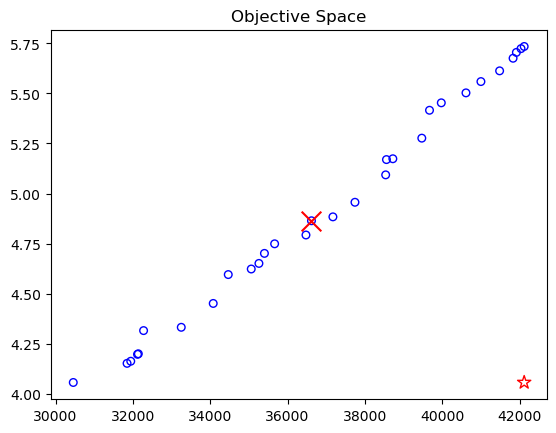

In [7]:
from sklearn.preprocessing import MinMaxScaler

nF = MinMaxScaler().fit_transform(F)
weights = np.array([0.5, 0.5])
from pymoo.decomposition.asf import ASF

decomp = ASF()
i = decomp.do(nF, 1 / weights).argmin()
print("Best regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))

plt.scatter(-F[:, 0], F[:, 1], s=30, facecolors="none", edgecolors="blue")
plt.scatter(-F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.scatter(
    -F.min(axis=0)[0],
    F.min(axis=0)[1],
    facecolors="none",
    edgecolors="red",
    marker="*",
    s=100,
    label="Ideal Point (Approx)",
)

plt.title("Objective Space")


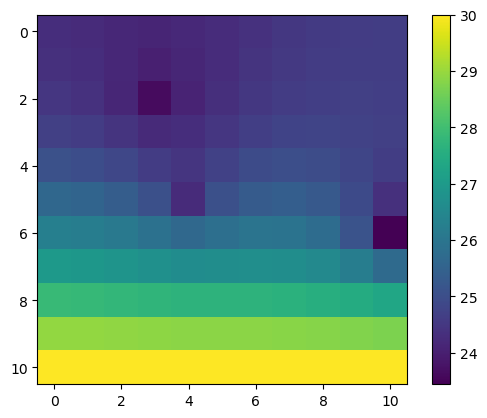

In [2]:
import os
import numpy as np
import pandas as pd
import flopy
from tempfile import TemporaryDirectory

# filename
temp_dir = TemporaryDirectory()
sim_ws = os.path.join(temp_dir.name)
sim_name = "IdealModel1"
gwfname = "gwf_" + sim_name
gwtname = "gwt_" + sim_name
#sim_ws = "C:/Users/ART/Desktop/mf6"
# units
length_units = "meters"
time_units = "days"

# Discretization
nper = 1
nlay = 1
nrow = 11
ncol = 11
delr = 1000
delc = 1000
top = 30
botm = -10
idomain = 1

# GWF
icelltype = 1  # 潜水含水层

k11 = np.full([11, 11], 90)  # 渗透系数
k11[:4, :6] = 150
k11[8:, :] = 60
k11[5:8, 9:] = 60

# Temporal discretization
perlen = 1000.0
nstp = 1
tsmult = 1.0
tdis_ds = []
tdis_ds.append((perlen, nstp, tsmult))

# Solver parameters
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0

# Initial conditions
# Starting Heads
strt = np.full([11, 11], 30, dtype=float)

# Boundary conditions
# wel_spd

wel_spd = [[0, 2, 3, -10000], [0, 5, 4, -10000], [0, 6, 10, -10000]]
wel_spd = {0: wel_spd}

# chd_spd
chd_spd = []
for i in np.arange(ncol):
    chd_spd.append([0, 10, i, 30.0])

sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)

gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=gwfname,
    save_flows=True,
    model_nam_file="{}.nam".format(gwfname),
)

ims = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename="{}.ims".format(gwfname),
)
sim.register_ims_package(ims, [gwf.name])

flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename="{}.dis".format(gwfname),
)

flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=False,
    icelltype=icelltype,
    k=k11,
    k33=k11,
    save_specific_discharge=True,
    filename="{}.npf".format(gwfname),
)

flopy.mf6.ModflowGwfic(gwf, strt=strt, filename="{}.ic".format(gwfname))

flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chd_spd),
    stress_period_data=chd_spd,
    save_flows=False,
    pname="CHD-1",
    filename="{}.chd".format(gwfname),
)

flopy.mf6.ModflowGwfwel(
    gwf,
    print_input=True,
    print_flows=True,
    stress_period_data=wel_spd,
    save_flows=True,
    pname="WEL-1",
    filename="{}.wel".format(gwfname),
)

flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord="{}.hds".format(gwfname),
    budget_filerecord="{}.bud".format(gwfname),
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

sim.write_simulation(silent=True)
success, buff = sim.run_simulation(silent=True)
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

head = gwf.oc.output.head().get_alldata()[0, 0]
import matplotlib.pyplot as plt
plt.imshow(head)
plt.colorbar()